In [95]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

## Match Data

In [22]:
# Load dataset
match_data_path = '/Users/yichaoma/Desktop/ATL/american_soccer_analysis_mls_xgoals_games_2025-01-22.csv'
match_df = pd.read_csv(match_data_path)

# Basic data summary
print(match_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493 entries, 0 to 492
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    493 non-null    object 
 1   Time    493 non-null    object 
 2   Home    493 non-null    object 
 3   HG      493 non-null    int64  
 4   HxGt    493 non-null    float64
 5   HxGp    493 non-null    float64
 6   Away    493 non-null    object 
 7   AG      493 non-null    int64  
 8   AxGt    493 non-null    float64
 9   AxGp    493 non-null    float64
 10  GD      493 non-null    int64  
 11  xGDt    493 non-null    float64
 12  xGDp    493 non-null    float64
 13  Final   493 non-null    int64  
 14  HxPts   493 non-null    float64
 15  AxPts   493 non-null    float64
dtypes: float64(8), int64(4), object(4)
memory usage: 61.8+ KB
None


In [23]:
match_df

,Date,Time,Home,HG,HxGt,HxGp,Away,AG,AxGt,AxGp,GD,xGDt,xGDp,Final,HxPts,AxPts
0,2024-10-19,21:00 EDT,ATX,3,2.01,2.02,COL,2,2.12,2.12,1,-0.11,-0.11,1,1.26,1.48
1,2024-10-19,21:00 EDT,FCD,1,0.50,0.50,SKC,1,1.85,1.93,0,-1.35,-1.43,1,0.38,2.43
2,2024-10-19,21:00 EDT,LAFC,3,1.77,1.77,SJE,1,1.52,1.52,2,0.25,0.25,2,1.50,1.25
3,2024-10-19,21:00 EDT,RSL,1,1.45,1.45,VAN,1,1.48,1.48,0,-0.02,-0.02,1,1.32,1.38
4,2024-10-19,21:00 EDT,SEA,1,0.96,0.97,POR,1,1.04,1.05,0,-0.08,-0.08,0,1.31,1.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488,2024-02-24,19:30 EST,CLT,1,1.61,1.65,NYC,0,0.64,0.64,1,0.97,1.00,1,2.26,0.49
489,2024-02-24,19:30 EST,PHI,2,1.76,1.77,CHI,2,1.66,1.69,0,0.10,0.08,0,1.45,1.29
490,2024-02-24,16:30 EST,LAFC,2,1.36,1.36,SEA,1,1.67,1.68,1,-0.31,-0.32,1,1.16,1.58
491,2024-02-24,14:00 EST,CLB,1,1.53,1.54,ATL,0,0.79,0.79,1,0.74,0.75,1,2.03,0.70


In [24]:
# Check missing values
print("\nMissing Values:")
print(match_df.isnull().sum())


Missing Values:
Date     0
Time     0
Home     0
HG       0
HxGt     0
HxGp     0
Away     0
AG       0
AxGt     0
AxGp     0
GD       0
xGDt     0
xGDp     0
Final    0
HxPts    0
AxPts    0
dtype: int64


In [25]:
# Check for duplicate rows
duplicates = match_df.duplicated(subset=['Date', 'Home', 'Away']).sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


In [26]:
# Calculate the final scores
def calculate_final_scores(row):
    if row['GD'] == row['Final']:
        return row['HG'], row['AG']  # No changes needed
    else:
        diff = row['Final'] - row['GD']
        if row['Final'] > 0:  # Home team wins
            return row['HG'] + diff, row['AG']
        else:  # Away team wins
            return row['HG'], row['AG'] + diff

# Apply the function to each row
match_df[['Final_Home_Goals', 'Final_Away_Goals']] = match_df.apply(
    lambda row: pd.Series(calculate_final_scores(row)), axis=1
)

# Print to verify
print(match_df[['Date', 'Home', 'Away', 'HG', 'AG', 'GD', 'Final', 'Final_Home_Goals', 'Final_Away_Goals']])


           Date  Home Away  HG  AG  GD  Final  Final_Home_Goals  \
0    2024-10-19   ATX  COL   3   2   1      1                 3   
1    2024-10-19   FCD  SKC   1   1   0      1                 2   
2    2024-10-19  LAFC  SJE   3   1   2      2                 3   
3    2024-10-19   RSL  VAN   1   1   0      1                 2   
4    2024-10-19   SEA  POR   1   1   0      0                 1   
..          ...   ...  ...  ..  ..  ..    ...               ...   
488  2024-02-24   CLT  NYC   1   0   1      1                 1   
489  2024-02-24   PHI  CHI   2   2   0      0                 2   
490  2024-02-24  LAFC  SEA   2   1   1      1                 2   
491  2024-02-24   CLB  ATL   1   0   1      1                 1   
492  2024-02-21   MIA  RSL   2   0   2      2                 2   

     Final_Away_Goals  
0                   2  
1                   1  
2                   1  
3                   1  
4                   1  
..                ...  
488                 0  
489

In [27]:
# Add the 'final_score' column as a tuple
match_df['final_score'] = match_df.apply(
    lambda row: (row['Final_Home_Goals'], row['Final_Away_Goals']), axis=1
)

final_match_df = match_df[['Date', 'Home', 'Away', 'HxGt', 'AxGt', 'final_score']]

final_match_df

,Date,Home,Away,HxGt,AxGt,final_score
0,2024-10-19,ATX,COL,2.01,2.12,"(3, 2)"
1,2024-10-19,FCD,SKC,0.50,1.85,"(2, 1)"
2,2024-10-19,LAFC,SJE,1.77,1.52,"(3, 1)"
3,2024-10-19,RSL,VAN,1.45,1.48,"(2, 1)"
4,2024-10-19,SEA,POR,0.96,1.04,"(1, 1)"
...,...,...,...,...,...,...
488,2024-02-24,CLT,NYC,1.61,0.64,"(1, 0)"
489,2024-02-24,PHI,CHI,1.76,1.66,"(2, 2)"
490,2024-02-24,LAFC,SEA,1.36,1.67,"(2, 1)"
491,2024-02-24,CLB,ATL,1.53,0.79,"(1, 0)"


### Visualiaztion

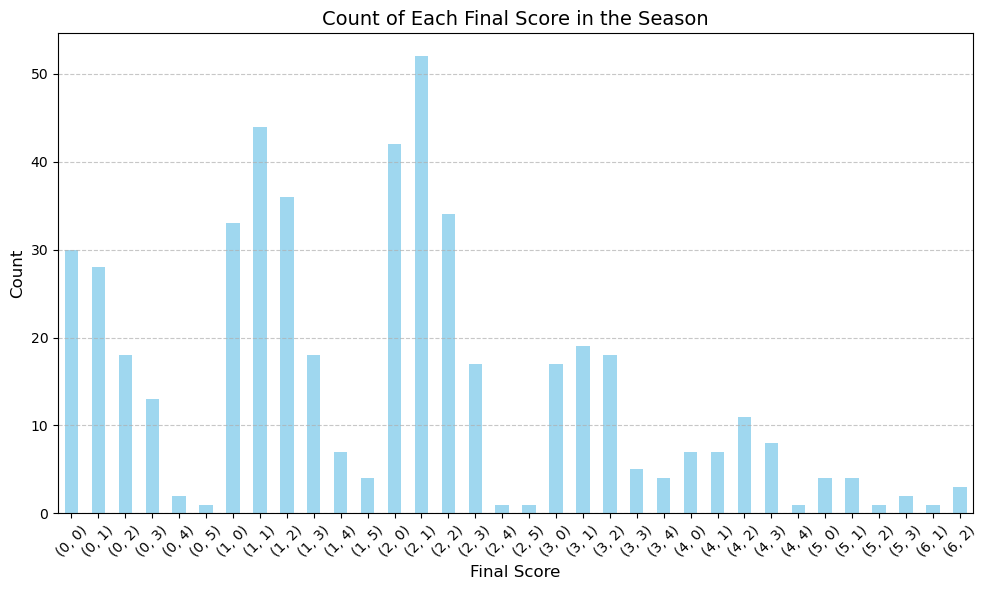

In [78]:
# Count the occurrences of each final score
score_counts = final_match_df["final_score"].value_counts()

# Plot the bar chart
plt.figure(figsize=(10, 6))
score_counts.sort_index().plot(kind="bar", color="skyblue", alpha=0.8)
plt.title("Count of Each Final Score in the Season", fontsize=14)
plt.xlabel("Final Score", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

/var/folders/j3/0tzprhyx6pv0px5_wnb383sm0000gn/T/ipykernel_42619/3478710263.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_match_df['performance'] = final_match_df['final_score'].apply(classify_performance)


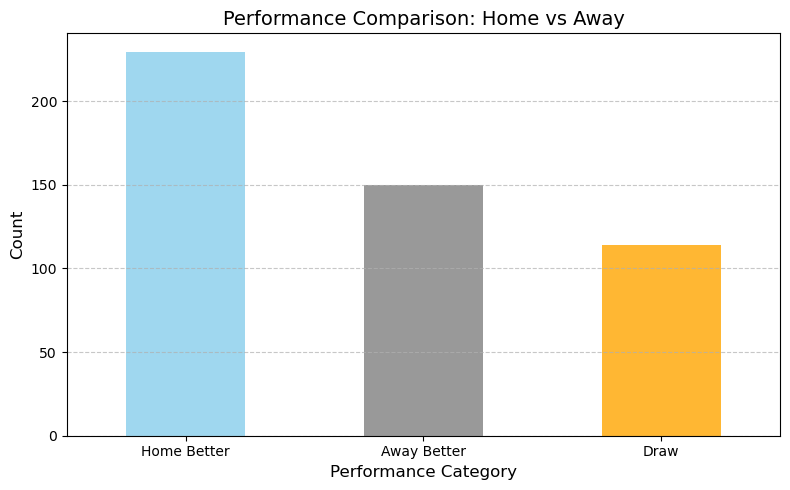

In [81]:
# Classify final scores into "Home Better", "Draw", "Away Better"
def classify_performance(score):
    if score[0] > score[1]:  # Home score is greater
        return "Home Better"
    elif score[0] < score[1]:  # Away score is greater
        return "Away Better"
    else:  # Scores are equal
        return "Draw"

# Apply classification
final_match_df['performance'] = final_match_df['final_score'].apply(classify_performance)

# Count occurrences of each category
performance_counts = final_match_df['performance'].value_counts()

# Plot grouped bar chart
plt.figure(figsize=(8, 5))
performance_counts.plot(kind='bar', color=['skyblue', 'gray', 'orange'], alpha=0.8)
plt.title("Performance Comparison: Home vs Away", fontsize=14)
plt.xlabel("Performance Category", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


/var/folders/j3/0tzprhyx6pv0px5_wnb383sm0000gn/T/ipykernel_42619/2399322075.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_match_df['normalized_score'] = final_match_df['final_score'].apply(lambda x: tuple(sorted(x)))


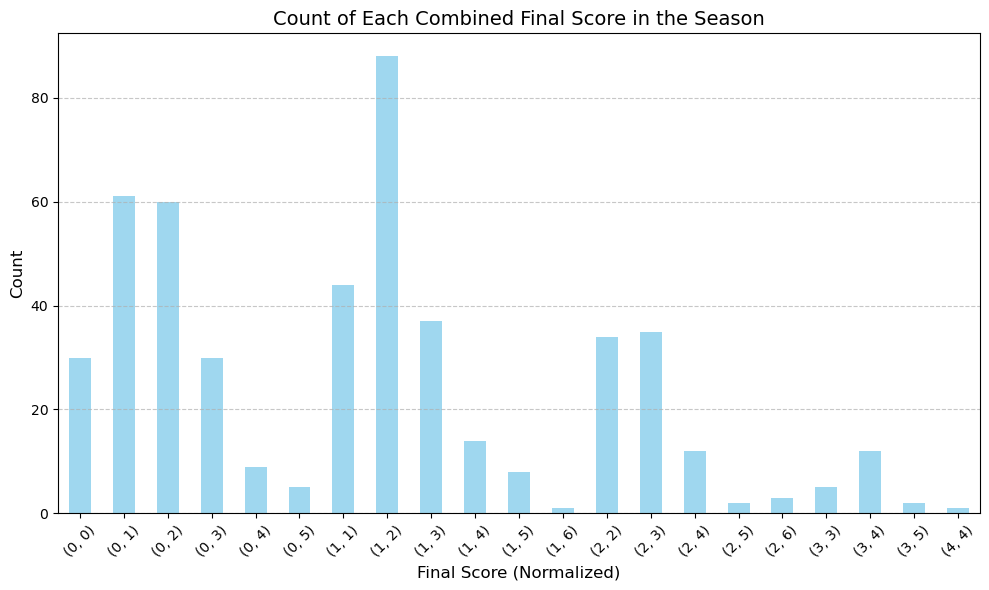

In [79]:
# Create a normalized final_score where (a, b) is always sorted as (min(a, b), max(a, b))
final_match_df['normalized_score'] = final_match_df['final_score'].apply(lambda x: tuple(sorted(x)))

# Count occurrences of each normalized final score
normalized_score_counts = final_match_df['normalized_score'].value_counts()

plt.figure(figsize=(10, 6))
normalized_score_counts.sort_index().plot(kind="bar", color="skyblue", alpha=0.8)
plt.title("Count of Each Combined Final Score in the Season", fontsize=14)
plt.xlabel("Final Score (Normalized)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


/var/folders/j3/0tzprhyx6pv0px5_wnb383sm0000gn/T/ipykernel_42619/3430194098.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_match_df['total_goals'] = final_match_df['normalized_score'].apply(lambda x: sum(x))


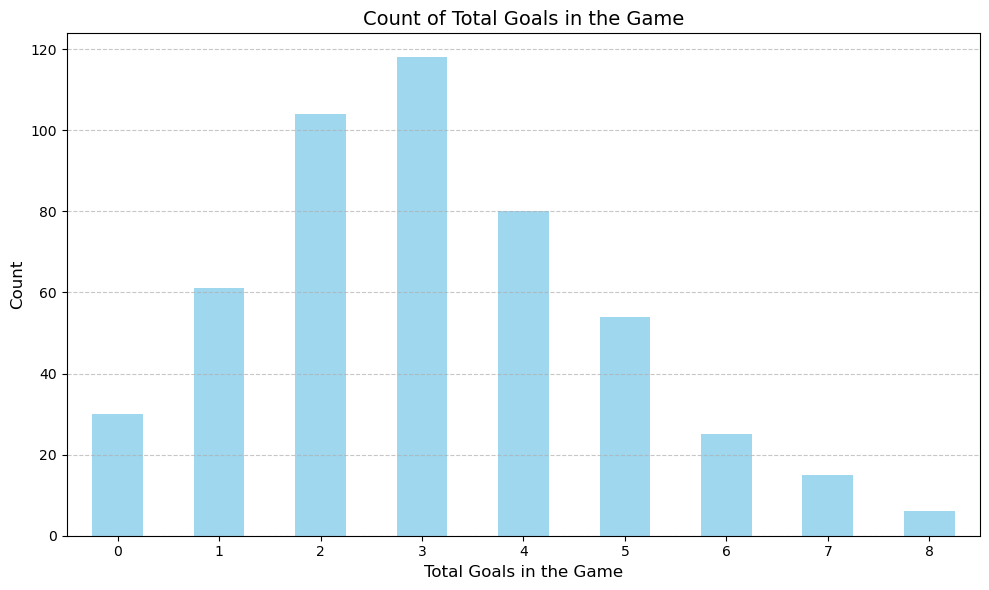

In [84]:
# Calculate the total goals for each match
final_match_df['total_goals'] = final_match_df['normalized_score'].apply(lambda x: sum(x))

# Count the occurrences of each total goal value
total_goals_count = final_match_df['total_goals'].value_counts().sort_index()

# Plot the bar chart
plt.figure(figsize=(10, 6))
total_goals_count.plot(kind='bar', color='skyblue', alpha=0.8)
plt.title("Count of Total Goals in the Game", fontsize=14)
plt.xlabel("Total Goals in the Game", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


### Automation

In [31]:
# Define the function to calculate final scores
def calculate_final_scores(row):
    if row['GD'] == row['Final']:
        return row['HG'], row['AG']  
    else:
        diff = row['Final'] - row['GD']
        if row['Final'] > 0:  # Home team wins
            return row['HG'] + diff, row['AG']
        else:  # Away team wins
            return row['HG'], row['AG'] + diff

def automate_pipeline(input_file, output_file):
    # Step 1: Data Ingestion
    match_df = pd.read_csv(input_file)
    
    # Step 2: Data Transformation
    # Calculate the final scores
    match_df[['Final_Home_Goals', 'Final_Away_Goals']] = match_df.apply(
        lambda row: pd.Series(calculate_final_scores(row)), axis=1
    )

    # Add the 'final_score' column as a tuple
    match_df['final_score'] = match_df.apply(
        lambda row: (row['Final_Home_Goals'], row['Final_Away_Goals']), axis=1
    )

    # Create the final DataFrame
    final_match_df = match_df[['Date', 'Home', 'Away', 'HxGt', 'AxGt', 'final_score']]

    # Step 3: Save the Processed Data
    final_match_df.to_csv(output_file, index=False)

    print(f"Pipeline executed successfully. Processed data saved to {output_file}")

if __name__ == "__main__":
    # Set input and output file paths
    input_file = '/Users/yichaoma/Desktop/ATL/american_soccer_analysis_mls_xgoals_games_2025-01-22.csv'
    output_file = '/Users/yichaoma/Desktop/ATL/final_match_data.csv'
    
    # Run the pipeline
    automate_pipeline(input_file, output_file)


Pipeline executed successfully. Processed data saved to /Users/yichaoma/Desktop/ATL/final_match_data.csv


## Salary

In [33]:
# Load dataset
salary_data_path = '/Users/yichaoma/Desktop/ATL/salary.csv'
salary_df = pd.read_csv(salary_data_path)

# Basic data summary
print(salary_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 894 entries, 0 to 893
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               0 non-null      float64
 1   Player                   894 non-null    object 
 2   Team                     894 non-null    object 
 3   Season                   894 non-null    int64  
 4   Position                 894 non-null    object 
 5   Base Salary              894 non-null    object 
 6   Guaranteed Compensation  894 non-null    object 
 7   Date                     894 non-null    object 
dtypes: float64(1), int64(1), object(6)
memory usage: 56.0+ KB
None


In [35]:
salary_df

,Unnamed: 0,Player,Team,Season,Position,Base Salary,Guaranteed Compensation,Date
0,NaN,Lionel Messi,MIA,2024,F,"$12,000,000","$20,446,668",2024-09-13
1,NaN,Lorenzo Insigne,TOR,2024,F,"$7,500,000","$15,400,000",2024-09-13
2,NaN,Sergio Busquets,MIA,2024,M,"$8,499,996","$8,774,996",2024-09-13
3,NaN,Sebastián Driussi,ATX,2024,M,"$4,500,000","$6,722,500",2024-09-13
4,NaN,Federico Bernardeschi,TOR,2024,F,"$3,125,000","$6,295,381",2024-09-13
...,...,...,...,...,...,...,...,...
889,NaN,Garrison Tubbs,DCU,2024,D,"$71,401","$71,401",2024-09-13
890,NaN,Ousman Jabang,MTL,2024,M,"$71,401","$71,401",2024-09-13
891,NaN,Malik Henry-Scott,FCD,2024,F,"$71,401","$71,401",2024-09-13
892,NaN,Stephen Afrifa,SKC,2024,F,"$71,401","$71,401",2024-09-13


In [37]:
# Drop the 'Unnamed: 0' column
salary_df = salary_df.drop(columns=['Unnamed: 0'], errors='ignore') 

# Check for missing values
missing_values = salary_df.isnull().sum()
print("Missing values per column:")
print(missing_values)

# Check for duplicated rows
duplicates = salary_df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

# Print the cleaned DataFrame info
print(salary_df.info())

# Display the first few rows of the DataFrame to verify
salary_df


Missing values per column:
Player                     0
Team                       0
Season                     0
Position                   0
Base Salary                0
Guaranteed Compensation    0
Date                       0
dtype: int64
Number of duplicate rows: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 894 entries, 0 to 893
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Player                   894 non-null    object
 1   Team                     894 non-null    object
 2   Season                   894 non-null    int64 
 3   Position                 894 non-null    object
 4   Base Salary              894 non-null    object
 5   Guaranteed Compensation  894 non-null    object
 6   Date                     894 non-null    object
dtypes: int64(1), object(6)
memory usage: 49.0+ KB
None


,Player,Team,Season,Position,Base Salary,Guaranteed Compensation,Date
0,Lionel Messi,MIA,2024,F,"$12,000,000","$20,446,668",2024-09-13
1,Lorenzo Insigne,TOR,2024,F,"$7,500,000","$15,400,000",2024-09-13
2,Sergio Busquets,MIA,2024,M,"$8,499,996","$8,774,996",2024-09-13
3,Sebastián Driussi,ATX,2024,M,"$4,500,000","$6,722,500",2024-09-13
4,Federico Bernardeschi,TOR,2024,F,"$3,125,000","$6,295,381",2024-09-13
...,...,...,...,...,...,...,...
889,Garrison Tubbs,DCU,2024,D,"$71,401","$71,401",2024-09-13
890,Ousman Jabang,MTL,2024,M,"$71,401","$71,401",2024-09-13
891,Malik Henry-Scott,FCD,2024,F,"$71,401","$71,401",2024-09-13
892,Stephen Afrifa,SKC,2024,F,"$71,401","$71,401",2024-09-13


In [40]:
# Ensure 'Guaranteed Compensation' and 'Base Salary' are numeric
salary_df['Guaranteed Compensation'] = salary_df['Guaranteed Compensation'].replace(
    {'\$': '', ',': ''}, regex=True
).astype(float)

salary_df['Base Salary'] = salary_df['Base Salary'].replace(
    {'\$': '', ',': ''}, regex=True
).astype(float)

# Filter data for the 2024 season
salary_2024_df = salary_df[salary_df['Season'] == 2024]

# Aggregate by team: Sum of Base Salary and Guaranteed Compensation
team_salary_df = salary_2024_df.groupby('Team', as_index=False).agg(
    {'Base Salary': 'sum', 'Guaranteed Compensation': 'sum'}
)

# Rank teams by Guaranteed Compensation (highest to lowest)
team_salary_df = team_salary_df.sort_values(by='Guaranteed Compensation', ascending=False).reset_index(drop=True)

# Add a rank column
team_salary_df['Rank'] = team_salary_df.index + 1

# Format numbers as 000,000,000.00
team_salary_df['Base Salary'] = team_salary_df['Base Salary'].apply(lambda x: f"{x:,.2f}")
team_salary_df['Guaranteed Compensation'] = team_salary_df['Guaranteed Compensation'].apply(lambda x: f"{x:,.2f}")

# Display the final table
print(team_salary_df)


    Team    Base Salary Guaranteed Compensation  Rank
0    MIA  30,716,557.00           41,708,281.00     1
1    TOR  19,366,492.00           31,659,848.00     2
2   LAFC  19,718,893.00           22,014,523.00     3
3    LAG  18,489,794.00           21,962,879.00     4
4    NSH  18,906,716.00           21,864,490.00     5
5    CIN  18,080,260.00           20,950,009.00     6
6    HOU  18,279,937.00           20,370,364.00     7
7    NER  17,472,742.00           18,883,233.00     8
8   NYRB  16,053,252.00           18,083,549.00     9
9    ATX  14,691,755.00           17,595,884.00    10
10   ORL  14,439,681.00           17,493,932.00    11
11   VAN  15,993,847.00           17,342,956.00    12
12   CHI  16,016,484.00           17,224,012.00    13
13   FCD  15,164,853.00           17,187,092.00    14
14   SEA  15,067,360.00           16,680,315.00    15
15   CLB  14,581,351.00           16,586,339.00    16
16   DCU  14,791,644.00           16,490,439.00    17
17   SKC  15,582,554.00     

In [41]:
# Check for missing values
missing_values = team_salary_df.isnull().sum()
print("Missing values per column:")
print(missing_values)

# Check for duplicated rows
duplicates = team_salary_df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Missing values per column:
Team                       0
Base Salary                0
Guaranteed Compensation    0
Rank                       0
dtype: int64
Number of duplicate rows: 0


In [87]:
# Initialize a points dictionary
points = {}

# Calculate points for each match
for index, row in final_match_df.iterrows():
    home_team = row['Home']
    away_team = row['Away']
    home_goals, away_goals = row['final_score']
    
    # Initialize teams in the points dictionary if not already present
    if home_team not in points:
        points[home_team] = 0
    if away_team not in points:
        points[away_team] = 0

    # Assign points based on match result
    if home_goals > away_goals:  # Home win
        points[home_team] += 3
    elif home_goals < away_goals:  # Away win
        points[away_team] += 3
    else:  # Draw
        points[home_team] += 1
        points[away_team] += 1

# Convert points dictionary to a DataFrame
standings = pd.DataFrame(points.items(), columns=['Team', 'Points'])

# Sort by points in descending order and add a rank column
standings = standings.sort_values(by='Points', ascending=False).reset_index(drop=True)
standings['Rank'] = standings.index + 1

# Display the standings table
print(standings)


    Team  Points  Rank
0    MIA      76     1
1    CLB      66     2
2   LAFC      66     3
3    LAG      66     4
4    RSL      59     5
5    CIN      56     6
6    SEA      54     7
7    MIN      53     8
8    HOU      51     9
9    NYC      50    10
10  NYRB      49    11
11   COL      48    12
12   ORL      48    13
13   CLT      48    14
14   POR      47    15
15   VAN      47    16
16   MTL      45    17
17   ATL      43    18
18   ATX      42    19
19   FCD      41    20
20   DCU      40    21
21   PHI      40    22
22   TOR      40    23
23   STL      39    24
24   NSH      38    25
25   NER      31    26
26   SKC      31    27
27   CHI      30    28
28   SJE      21    29


### Visualization

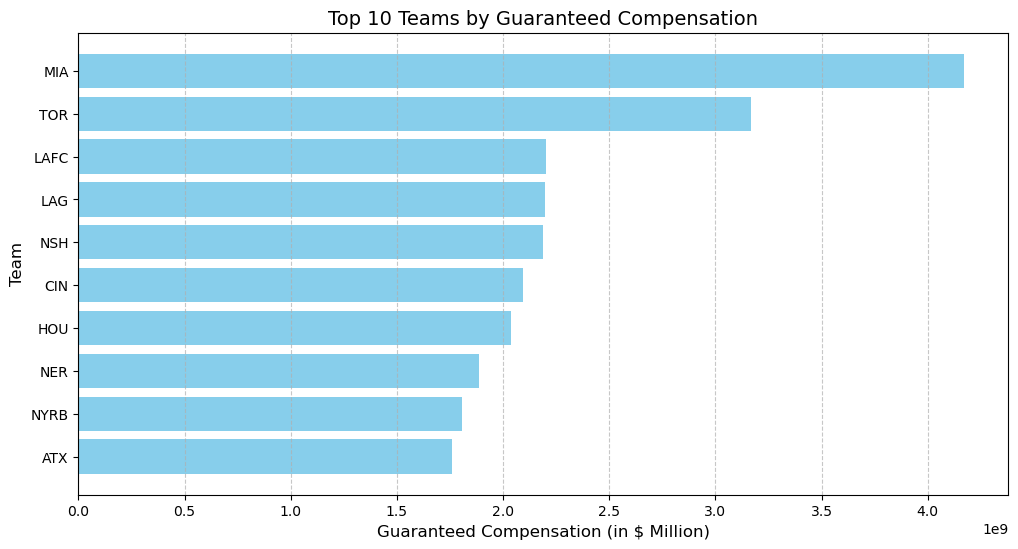

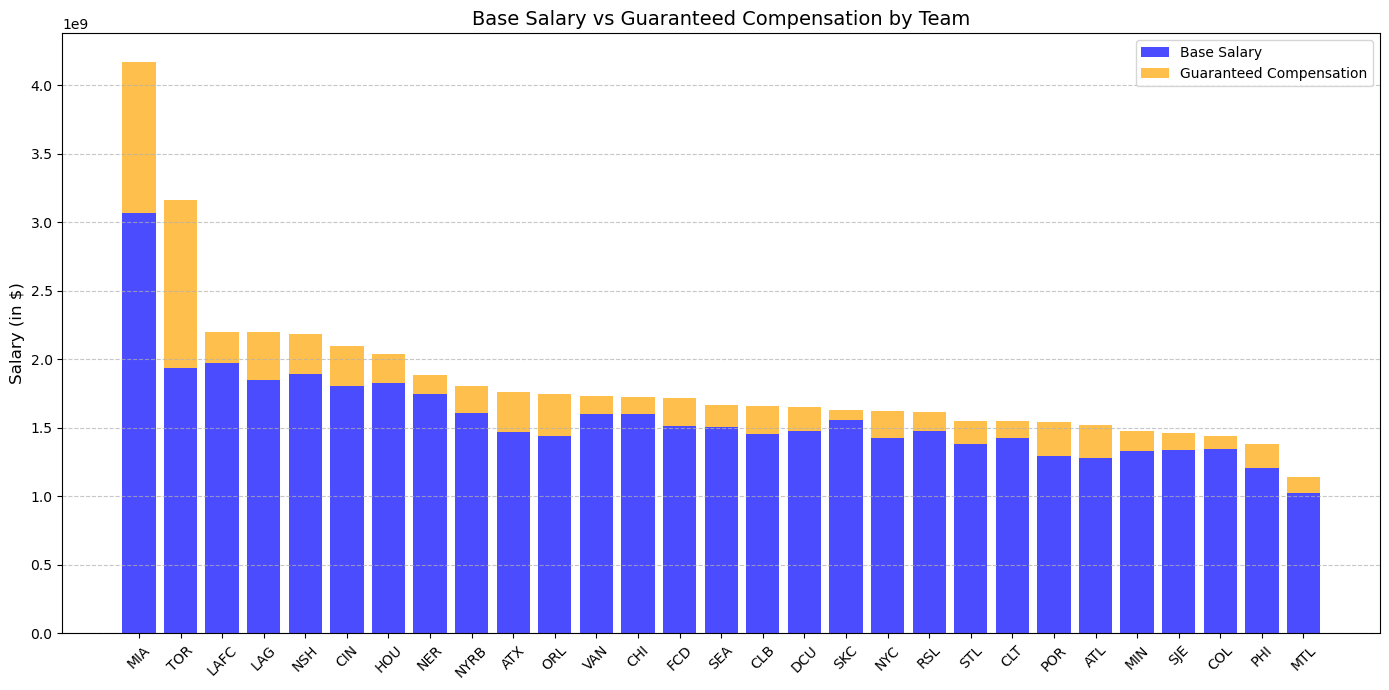

In [86]:
# Convert 'Base Salary' and 'Guaranteed Compensation' back to float for plotting
team_salary_df['Base Salary'] = team_salary_df['Base Salary'].replace({',': '', '\.': ''}, regex=True).astype(float)
team_salary_df['Guaranteed Compensation'] = team_salary_df['Guaranteed Compensation'].replace({',': '', '\.': ''}, regex=True).astype(float)

# Top 10 Teams by Guaranteed Compensation
top_10_teams = team_salary_df.nlargest(10, "Guaranteed Compensation")

plt.figure(figsize=(12, 6))
plt.barh(top_10_teams["Team"], top_10_teams["Guaranteed Compensation"], color='skyblue')
plt.xlabel("Guaranteed Compensation (in $ Million)", fontsize=12)
plt.ylabel("Team", fontsize=12)
plt.title("Top 10 Teams by Guaranteed Compensation", fontsize=14)
plt.gca().invert_yaxis()  # Invert the y-axis for better readability
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Base Salary vs Guaranteed Compensation for All Teams
plt.figure(figsize=(14, 7))
plt.bar(team_salary_df["Team"], team_salary_df["Base Salary"], label="Base Salary", color="blue", alpha=0.7)
plt.bar(team_salary_df["Team"], team_salary_df["Guaranteed Compensation"] - team_salary_df["Base Salary"], 
        bottom=team_salary_df["Base Salary"], label="Guaranteed Compensation", color="orange", alpha=0.7)
plt.xticks(rotation=45, fontsize=10)
plt.ylabel("Salary (in $)", fontsize=12)
plt.title("Base Salary vs Guaranteed Compensation by Team", fontsize=14)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

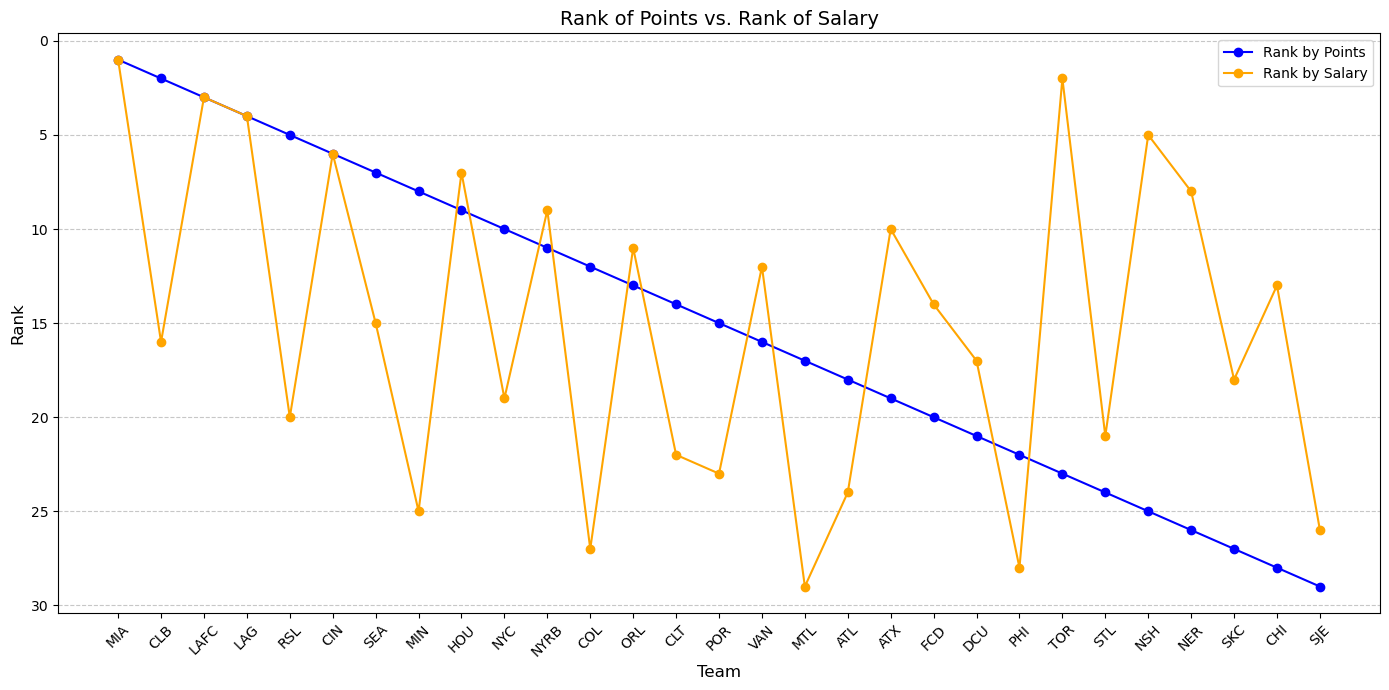

In [88]:
# Merge standings and team_salary_df on Team
combined_df = standings.merge(team_salary_df[['Team', 'Rank']], on='Team', suffixes=('_points', '_salary'))

# Plot the rank of points and salary
plt.figure(figsize=(14, 7))
plt.plot(combined_df['Rank_points'], label='Rank by Points', marker='o', linestyle='-', color='blue')
plt.plot(combined_df['Rank_salary'], label='Rank by Salary', marker='o', linestyle='-', color='orange')
plt.xticks(ticks=range(len(combined_df)), labels=combined_df['Team'], rotation=45)
plt.xlabel("Team", fontsize=12)
plt.ylabel("Rank", fontsize=12)
plt.title("Rank of Points vs. Rank of Salary", fontsize=14)
plt.gca().invert_yaxis()  # Reverse the rank order (1 is top)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


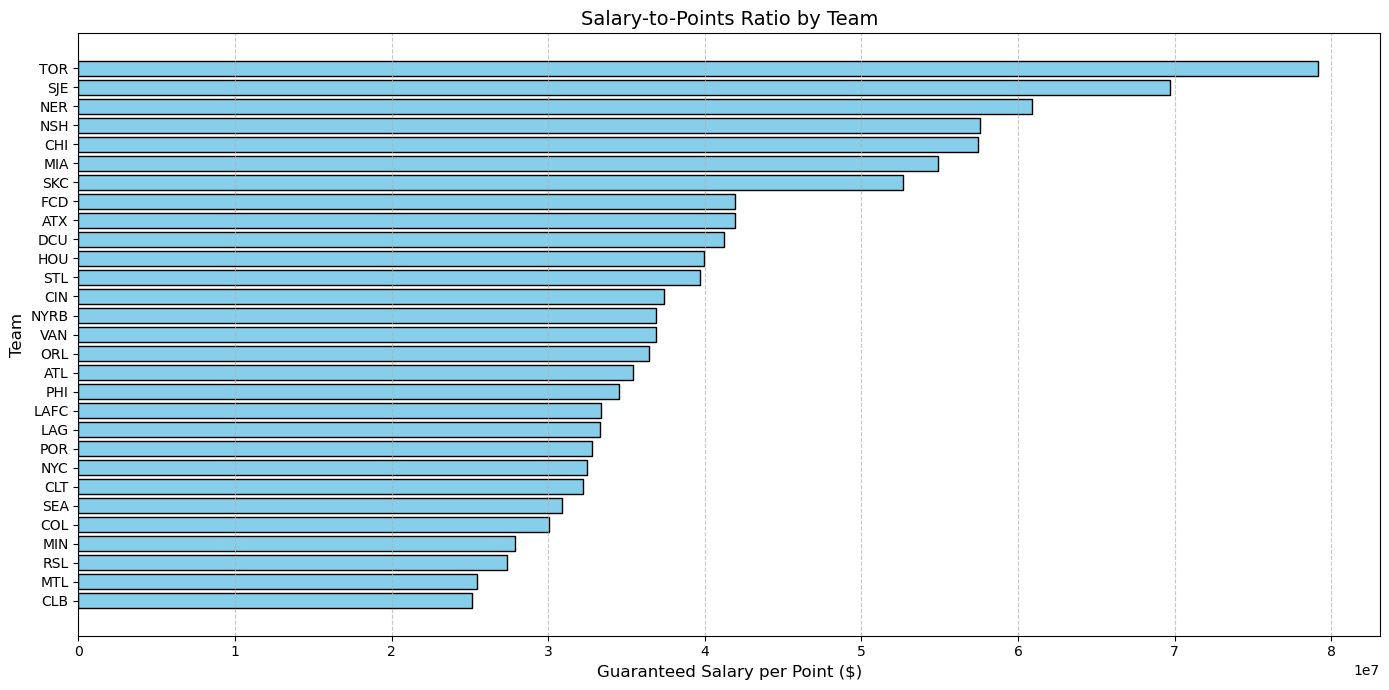

In [92]:
# Merge standings and team_salary_df on Team
combined_df = standings.merge(team_salary_df[['Team', 'Guaranteed Compensation']], on='Team')

# Convert 'Guaranteed Compensation' to numeric (if not already done)
combined_df['Guaranteed Compensation'] = combined_df['Guaranteed Compensation'].replace(
    {'\$': '', ',': ''}, regex=True
).astype(float)

# Calculate salary-to-points ratio
combined_df['Salary-to-Points Ratio'] = combined_df['Guaranteed Compensation'] / combined_df['Points']

# Sort by Salary-to-Points Ratio
combined_df = combined_df.sort_values(by='Salary-to-Points Ratio', ascending=True)

# Visualization
plt.figure(figsize=(14, 7))
plt.barh(combined_df['Team'], combined_df['Salary-to-Points Ratio'], color='skyblue', edgecolor='black')
plt.xlabel("Guaranteed Salary per Point ($)", fontsize=12)
plt.ylabel("Team", fontsize=12)
plt.title("Salary-to-Points Ratio by Team", fontsize=14)
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


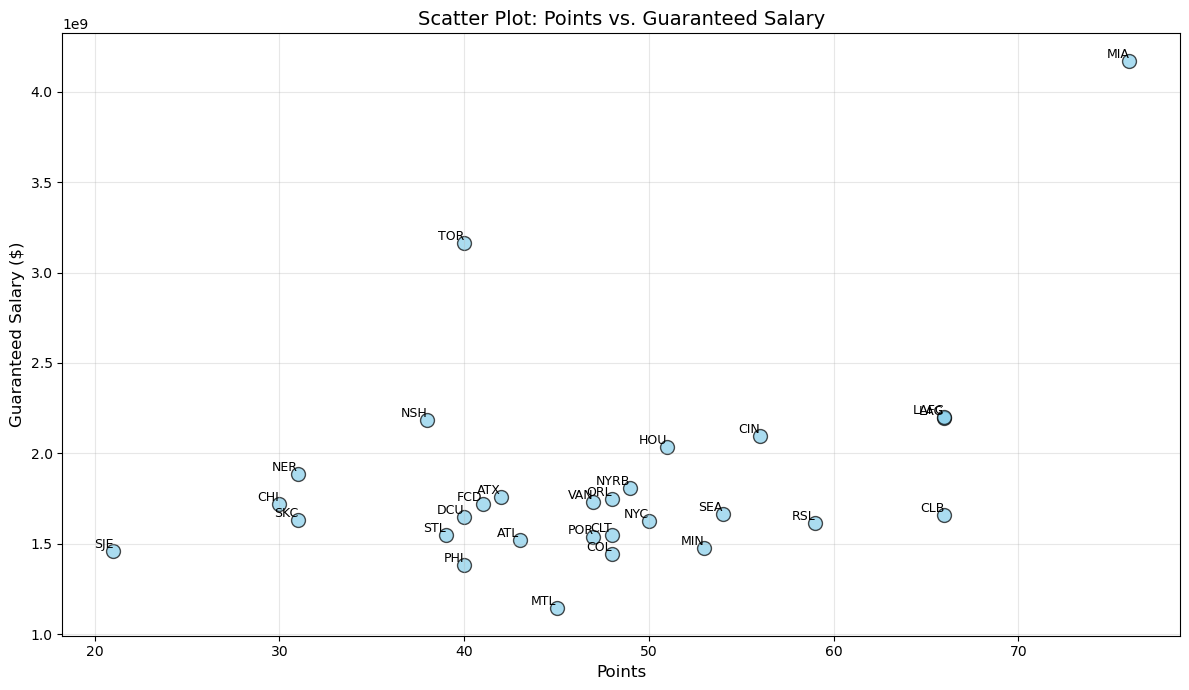

In [91]:
# Scatter plot for Points vs. Guaranteed Salary
plt.figure(figsize=(12, 7))
plt.scatter(
    combined_df['Points'], 
    combined_df['Guaranteed Compensation'], 
    color='skyblue', edgecolor='black', s=100, alpha=0.7
)

# Add labels to each point (team names)
for i, row in combined_df.iterrows():
    plt.text(row['Points'], row['Guaranteed Compensation'], row['Team'], fontsize=9, ha='right', va='bottom')

# Set axis labels and title
plt.xlabel("Points", fontsize=12)
plt.ylabel("Guaranteed Salary ($)", fontsize=12)
plt.title("Scatter Plot: Points vs. Guaranteed Salary", fontsize=14)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

/Users/yichaoma/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yichaoma/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yichaoma/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yichaoma/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will c

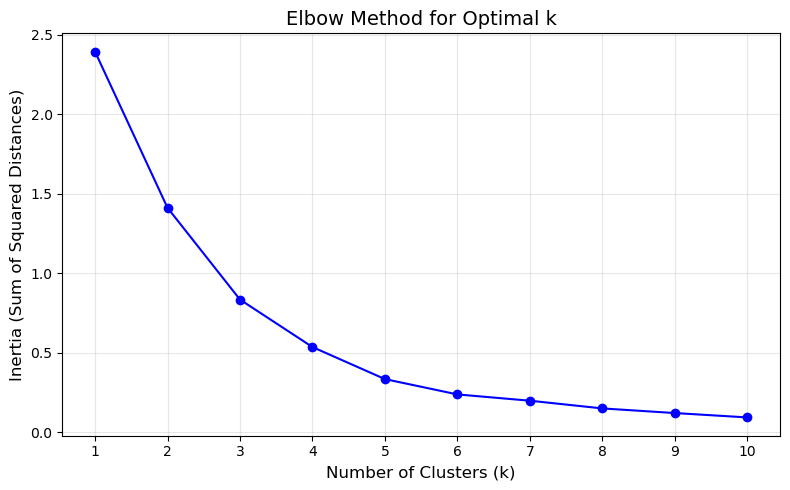

In [96]:
# Normalize data
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# Perform Elbow Method
inertia = []  # Sum of squared distances
k_values = range(1, 11)  # Test for clusters from 1 to 10

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method results
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o', linestyle='-', color='b')
plt.xticks(k_values)
plt.xlabel("Number of Clusters (k)", fontsize=12)
plt.ylabel("Inertia (Sum of Squared Distances)", fontsize=12)
plt.title("Elbow Method for Optimal k", fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


/Users/yichaoma/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


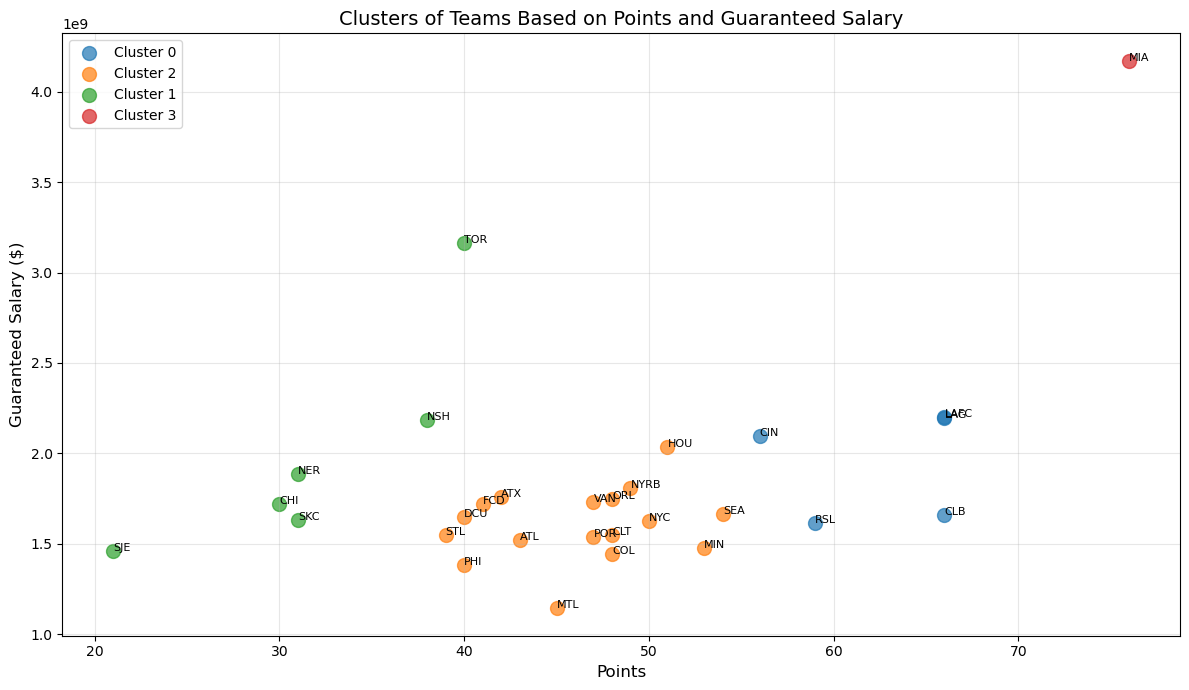

In [97]:
# Apply K-Means
kmeans = KMeans(n_clusters=4, random_state=42)
combined_df['Cluster'] = kmeans.fit_predict(scaled_features)

# Visualize Clusters
plt.figure(figsize=(12, 7))
for cluster in combined_df['Cluster'].unique():
    cluster_data = combined_df[combined_df['Cluster'] == cluster]
    plt.scatter(
        cluster_data['Points'], 
        cluster_data['Guaranteed Compensation'], 
        label=f"Cluster {cluster}", s=100, alpha=0.7
    )

# Annotate points
for i, row in combined_df.iterrows():
    plt.text(row['Points'], row['Guaranteed Compensation'], row['Team'], fontsize=8)

# Add labels and legend
plt.xlabel("Points", fontsize=12)
plt.ylabel("Guaranteed Salary ($)", fontsize=12)
plt.title("Clusters of Teams Based on Points and Guaranteed Salary", fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### Automation

In [56]:
def process_team_salary(salary_df, season):
    """
    Processes salary data to aggregate and rank teams by salary.
    
    """
    # Ensure 'Guaranteed Compensation' and 'Base Salary' are numeric
    salary_df['Guaranteed Compensation'] = salary_df['Guaranteed Compensation'].replace(
        {'\$': '', ',': ''}, regex=True
    ).astype(float)
    salary_df['Base Salary'] = salary_df['Base Salary'].replace(
        {'\$': '', ',': ''}, regex=True
    ).astype(float)

    # Filter data for the specified season
    salary_2024_df = salary_df[salary_df['Season'] == season]

    # Aggregate by team: Sum of Base Salary and Guaranteed Compensation
    team_salary_df = salary_2024_df.groupby('Team', as_index=False).agg(
        {'Base Salary': 'sum', 'Guaranteed Compensation': 'sum'}
    )

    # Rank teams by Guaranteed Compensation (highest to lowest)
    team_salary_df = team_salary_df.sort_values(by='Guaranteed Compensation', ascending=False).reset_index(drop=True)

    # Add a rank column
    team_salary_df['Rank'] = team_salary_df.index + 1

    # Format numbers as 000,000,000.00
    team_salary_df['Base Salary'] = team_salary_df['Base Salary'].apply(lambda x: f"{x:,.2f}")
    team_salary_df['Guaranteed Compensation'] = team_salary_df['Guaranteed Compensation'].apply(lambda x: f"{x:,.2f}")

    return team_salary_df


In [58]:
salary_data_path = "/Users/yichaoma/Desktop/ATL/salary.csv"  
salary_df = pd.read_csv(salary_data_path)

# Process team salary for the 2024 season
team_salary_df = process_team_salary(salary_df, season=2024)

# Save the resulting DataFrame to the specified path
output_path = "/Users/yichaoma/Desktop/ATL/team_salary.csv"
team_salary_df.to_csv(output_path, index=False)

# Player Stats

In [68]:
# Load datasets
xgoal = pd.read_csv("/Users/yichaoma/Desktop/ATL/xgoals.csv", index_col=0)
xpass = pd.read_csv("/Users/yichaoma/Desktop/ATL/xpass.csv", index_col=0)
goals_added = pd.read_csv("/Users/yichaoma/Desktop/ATL/goals_added.csv", index_col=0)

# Select specific columns to join from xpass and goals_added
xpass_columns = ["Player", "Passes", "Pass %", "xPass %", "Score", "Per100", "Distance", "Vertical", "Touch %", "Games"]
goals_added_columns = ["Player", "Dribbling", "Fouling", "Interrupting", "Passing", "Receiving", "Shooting", "Goals Added"]

# Keep only the necessary columns for the joins
xpass_filtered = xpass[xpass_columns]
goals_added_filtered = goals_added[goals_added_columns]

# Outer join to combine datasets
stat_df = xgoal.merge(xpass_filtered, on="Player", how="outer").merge(goals_added_filtered, on="Player", how="outer")

# Handle missing values: Fill with NaN (leave missing as is)
stat_df.fillna(value=pd.NA, inplace=True)


stat_df


,Player,Team,Season,Position,Minutes,Shots,SoT,G,xG,xPlace,...,Vertical,Touch %,Games,Dribbling,Fouling,Interrupting,Passing,Receiving,Shooting,Goals Added
0,Aaron Boupendza,CIN,2024,ST,655,18,9,2,2.15,0.21,...,1.39,2.7%,14,-0.06,-0.06,0.04,-0.29,-0.42,-0.08,-0.88
1,Aaron Herrera,DCU,2024,FB,2982,31,9,1,1.50,-0.07,...,5.47,11.3%,30,0.22,0.10,0.85,1.37,-0.01,0.09,2.62
2,Aaron Long,LAFC,2024,CB,2655,8,3,1,0.79,0.62,...,7.06,9.2%,29,-0.50,-0.15,0.85,-0.29,-0.29,-0.05,-0.42
3,Abraham Romero,CLB,2024,GK,141,0,0,0,0.00,0.00,...,20.75,2.6%,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Adam Beaudry,COL,2024,GK,102,0,0,0,0.00,0.00,...,33.76,5.0%,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
801,Zorhan Bassong,SKC,2024,FB,1416,4,0,0,0.17,-0.17,...,4.40,6.8%,21,0.07,-0.45,-0.15,0.26,-0.11,-0.17,-0.56
802,Édier Ocampo,VAN,2024,FB,201,5,3,0,0.32,0.30,...,-1.70,2.6%,6,-0.00,0.04,-0.01,-0.25,0.06,0.05,-0.12
803,Érik Dueñas,LAFC,2024,CM,452,1,0,0,0.14,-0.14,...,2.47,2.9%,14,-0.13,-0.01,0.26,-0.16,-0.04,-0.10,-0.17
804,Óscar Ustari,MIA,2024,GK,97,0,0,0,0.00,0.00,...,17.45,6.9%,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [125]:
import pandas as pd

def automate_stat_df_creation(xgoal_path, xpass_path, goals_added_path, output_path):
    """
    Automates the process of loading, filtering, merging datasets, and saving the final DataFrame to a CSV file.

    Returns:
        pd.DataFrame: The final merged DataFrame.
    """
    # Load datasets
    xgoal = pd.read_csv(xgoal_path, index_col=0)
    xpass = pd.read_csv(xpass_path, index_col=0)
    goals_added = pd.read_csv(goals_added_path, index_col=0)

    # Select specific columns to join from xpass and goals_added
    xpass_columns = ["Player", "Passes", "Pass %", "xPass %", "Score", "Per100", "Distance", "Vertical", "Touch %", "Games"]
    goals_added_columns = ["Player", "Dribbling", "Fouling", "Interrupting", "Passing", "Receiving", "Shooting", "Goals Added"]

    # Keep only the necessary columns for the joins
    xpass_filtered = xpass[xpass_columns]
    goals_added_filtered = goals_added[goals_added_columns]

    # Outer join to combine datasets
    stat_df = xgoal.merge(xpass_filtered, on="Player", how="outer").merge(goals_added_filtered, on="Player", how="outer")

    # Handle missing values: Fill with NaN (leave missing as is)
    stat_df.fillna(value=pd.NA, inplace=True)

    # Save the final DataFrame to a CSV file
    stat_df.to_csv(output_path, index=False)
    
    print(f"Final merged DataFrame saved to {output_path}")
    return stat_df

xgoal_path = "/Users/yichaoma/Desktop/ATL/xgoals.csv"
xpass_path = "/Users/yichaoma/Desktop/ATL/xpass.csv"
goals_added_path = "/Users/yichaoma/Desktop/ATL/goals_added.csv"
output_path = "/Users/yichaoma/Desktop/ATL/player_stat_df.csv"

# Generate the final stat_df and save it to CSV
stat_df = automate_stat_df_creation(xgoal_path, xpass_path, goals_added_path, output_path)

# Display the resulting DataFrame
print(stat_df)

Final merged DataFrame saved to /Users/yichaoma/Desktop/ATL/player_stat_df.csv
              Player  Team  Season Position  Minutes  Shots  SoT  G    xG  \
0    Aaron Boupendza   CIN    2024       ST      655     18    9  2  2.15   
1      Aaron Herrera   DCU    2024       FB     2982     31    9  1  1.50   
2         Aaron Long  LAFC    2024       CB     2655      8    3  1  0.79   
3     Abraham Romero   CLB    2024       GK      141      0    0  0  0.00   
4       Adam Beaudry   COL    2024       GK      102      0    0  0  0.00   
..               ...   ...     ...      ...      ...    ...  ... ..   ...   
801   Zorhan Bassong   SKC    2024       FB     1416      4    0  0  0.17   
802     Édier Ocampo   VAN    2024       FB      201      5    3  0  0.32   
803      Érik Dueñas  LAFC    2024       CM      452      1    0  0  0.14   
804     Óscar Ustari   MIA    2024       GK       97      0    0  0  0.00   
805     Žan Kolmanič   ATX    2024       FB      619      3    0  0  0.15 

In [69]:
# Check for missing values
missing_values = stat_df.isnull().sum()
print("Missing values per column:")
print(missing_values)

# Check for duplicated rows
duplicates = stat_df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Missing values per column:
Player           0
Team             0
Season           0
Position         0
Minutes          0
Shots            0
SoT              0
G                0
xG               0
xPlace           0
G-xG             0
KeyP             0
A                0
xA               0
A-xA             0
G+A              0
xG+xA            0
PA               0
xPA              0
Passes           0
Pass %           0
xPass %          0
Score            0
Per100           0
Distance         0
Vertical         0
Touch %          0
Games            0
Dribbling       65
Fouling         65
Interrupting    65
Passing         65
Receiving       65
Shooting        65
Goals Added     65
dtype: int64
Number of duplicate rows: 0


In [71]:
# Drop rows with any NaN values
stat_df_cleaned = stat_df.dropna()

# Display the cleaned DataFrame
print(stat_df_cleaned)


              Player  Team  Season Position  Minutes  Shots  SoT  G    xG  \
0    Aaron Boupendza   CIN    2024       ST      655     18    9  2  2.15   
1      Aaron Herrera   DCU    2024       FB     2982     31    9  1  1.50   
2         Aaron Long  LAFC    2024       CB     2655      8    3  1  0.79   
5    Adilson Malanda   CLT    2024       CB     3271      6    3  1  0.82   
6    Adolfo Enriquez   POR    2024       AM       10      0    0  0  0.00   
..               ...   ...     ...      ...      ...    ...  ... ..   ...   
800      Zavier Gozo   RSL    2024       ST       19      0    0  0  0.00   
801   Zorhan Bassong   SKC    2024       FB     1416      4    0  0  0.17   
802     Édier Ocampo   VAN    2024       FB      201      5    3  0  0.32   
803      Érik Dueñas  LAFC    2024       CM      452      1    0  0  0.14   
805     Žan Kolmanič   ATX    2024       FB      619      3    0  0  0.15   

     xPlace  ...  Vertical  Touch %  Games  Dribbling  Fouling  Interruptin

In [72]:
# Check for missing values
missing_values = stat_df_cleaned.isnull().sum()
print("Missing values per column:")
print(missing_values)

# Check for duplicated rows
duplicates = stat_df_cleaned.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Missing values per column:
Player          0
Team            0
Season          0
Position        0
Minutes         0
Shots           0
SoT             0
G               0
xG              0
xPlace          0
G-xG            0
KeyP            0
A               0
xA              0
A-xA            0
G+A             0
xG+xA           0
PA              0
xPA             0
Passes          0
Pass %          0
xPass %         0
Score           0
Per100          0
Distance        0
Vertical        0
Touch %         0
Games           0
Dribbling       0
Fouling         0
Interrupting    0
Passing         0
Receiving       0
Shooting        0
Goals Added     0
dtype: int64
Number of duplicate rows: 0


### Minutes per goal

In [98]:
# Calculate the ratio of minutes per goal
stat_df_cleaned['Minutes_per_Goal'] = stat_df_cleaned['Minutes'] / stat_df_cleaned['G']

# Handle cases where goals are 0 to avoid division by zero
stat_df_cleaned['Minutes_per_Goal'] = stat_df_cleaned['Minutes_per_Goal'].replace([float('inf')], pd.NA)

# Drop rows where the calculation is not valid
stat_df_cleaned = stat_df_cleaned.dropna(subset=['Minutes_per_Goal'])

# Rank by Minutes_per_Goal
stat_df_cleaned = stat_df_cleaned.sort_values(by='Minutes_per_Goal', ascending=True).reset_index(drop=True)

# Display the top players with Minutes, Goals, and Minutes per Goal
result = stat_df_cleaned[['Player', 'Minutes', 'G', 'Minutes_per_Goal']]
print(result)


              Player  Minutes   G Minutes_per_Goal
0    Lawrence Ennali       53   1             53.0
1        Tomás Ángel       81   1             81.0
2       Lionel Messi     1690  20             84.5
3       Talles Magno       91   1             91.0
4    Karol Swiderski      576   6             96.0
..               ...      ...  ..              ...
407    Juan Mosquera     3101   1           3101.0
408  Cristian Roldan     3174   1           3174.0
409   Michael Boxall     3215   1           3215.0
410  Adilson Malanda     3271   1           3271.0
411       Kai Wagner     3290   1           3290.0

[412 rows x 4 columns]


/var/folders/j3/0tzprhyx6pv0px5_wnb383sm0000gn/T/ipykernel_42619/1259791647.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stat_df_cleaned['Minutes_per_Goal'] = stat_df_cleaned['Minutes'] / stat_df_cleaned['G']
/var/folders/j3/0tzprhyx6pv0px5_wnb383sm0000gn/T/ipykernel_42619/1259791647.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stat_df_cleaned['Minutes_per_Goal'] = stat_df_cleaned['Minutes_per_Goal'].replace([float('inf')], pd.NA)


we have players who only play 51 or 81 minutes that get listed, we need a filter

In [102]:
# Filter players with more than 5 goals
stat_df_cleaned_filtered = stat_df_cleaned[stat_df_cleaned['Minutes'] > 900]

# Rank by Minutes_per_Goal
stat_df_cleaned_filtered = stat_df_cleaned_filtered.sort_values(by='Minutes_per_Goal', ascending=True).reset_index(drop=True)

# Display the top players with Minutes, Goals, and Minutes per Goal
result_filtered = stat_df_cleaned_filtered[['Player', 'Minutes', 'G', 'Minutes_per_Goal']]
result_filtered.head(20)

,Player,Minutes,G,Minutes_per_Goal
0,Lionel Messi,1690,20,84.5
1,Alonso Martínez,1668,16,104.25
2,Luis Suárez,2165,20,108.25
3,Cucho Hernández,2369,19,124.684211
4,Christian Benteke,2958,23,128.608696
5,Josef Martínez,1528,11,138.909091
6,Dejan Joveljic,2108,15,140.533333
7,Felipe Mora,2109,14,150.642857
8,Cristian Arango,2571,17,151.235294
9,Ramiro Enrique,1229,8,153.625


### Score efficiency

In [107]:
# Filter players with more than 5 goals
stat_df_filtered = stat_df_cleaned[stat_df_cleaned['G'] > 5]

# Rank players by G-xG
stat_df_filtered = stat_df_filtered.sort_values(by='G-xG', ascending=False).reset_index(drop=True)

# Display the players with Goals, xGoals, and G-xG
result_g_xg = stat_df_filtered[['Player', 'G', 'xG', 'G-xG', 'Shots', 'SoT']]
result_g_xg.head(20)


,Player,G,xG,G-xG,Shots,SoT
0,Lionel Messi,20,11.74,8.26,84,41
1,Luis Suárez,20,12.30,7.70,74,49
2,Alonso Martínez,16,9.28,6.72,55,27
3,Mateusz Bogusz,15,8.59,6.41,85,38
4,Facundo Torres,14,8.70,5.30,61,30
5,Petar Musa,16,10.78,5.22,87,31
6,Cucho Hernández,19,14.17,4.83,135,43
7,Andrés Gómez,13,8.68,4.32,68,33
8,Ryan Gauld,10,6.06,3.94,50,23
9,Evander,15,11.40,3.60,96,41


In [110]:
# Calculate Shots to Goals Conversion Rate
stat_df_filtered['Conversion Rate (%)'] = (stat_df_filtered['G'] / stat_df_filtered['Shots']) * 100

# Calculate Shots on Target Percentage (SoT%)
stat_df_filtered['SoT%'] = (stat_df_filtered['SoT'] / stat_df_filtered['Shots']) * 100

# Display players with Conversion Rate and SoT%
result_efficiency = stat_df_filtered[['Player', 'G', 'xG', 'G-xG', 'Shots', 'SoT', 'Conversion Rate (%)', 'SoT%']].sort_values(
    by='Conversion Rate (%)', ascending=False
).reset_index(drop=True)

# Display the top players
result_efficiency.head(20)


,Player,G,xG,G-xG,Shots,SoT,Conversion Rate (%),SoT%
0,Dániel Gazdag,17,13.68,3.32,50,34,34.000000,68.000000
1,Alonso Martínez,16,9.28,6.72,55,27,29.090909,49.090909
2,Luis Suárez,20,12.30,7.70,74,49,27.027027,66.216216
3,Dejan Joveljic,15,14.25,0.75,59,32,25.423729,54.237288
4,Christian Benteke,23,19.57,3.43,94,47,24.468085,50.000000
5,Josef Martínez,11,9.18,1.82,46,21,23.913043,45.652174
6,Lionel Messi,20,11.74,8.26,84,41,23.809524,48.809524
7,Karol Swiderski,6,6.09,-0.09,26,13,23.076923,50.000000
8,Facundo Torres,14,8.70,5.30,61,30,22.950820,49.180328
9,Leonardo Campana,8,5.83,2.17,35,17,22.857143,48.571429


In [111]:
# Display players with Conversion Rate and SoT%
result_efficiency = stat_df_filtered[['Player', 'G', 'xG', 'G-xG', 'Shots', 'SoT', 'Conversion Rate (%)', 'SoT%']].sort_values(
    by='SoT%', ascending=False
).reset_index(drop=True)

# Display the top players
result_efficiency.head(20)

,Player,G,xG,G-xG,Shots,SoT,Conversion Rate (%),SoT%
0,Dániel Gazdag,17,13.68,3.32,50,34,34.000000,68.000000
1,Luis Suárez,20,12.30,7.70,74,49,27.027027,66.216216
2,Dejan Joveljic,15,14.25,0.75,59,32,25.423729,54.237288
3,Kelvin Yeboah,7,5.95,1.05,32,17,21.875000,53.125000
4,Liel Abada,7,6.69,0.31,53,28,13.207547,52.830189
5,Jamal Thiaré,6,5.47,0.53,27,14,22.222222,51.851852
6,Daniel Ríos,7,6.46,0.54,43,22,16.279070,51.162791
7,Karol Swiderski,6,6.09,-0.09,26,13,23.076923,50.000000
8,Bongokuhle Hlongwane,11,9.28,1.72,52,26,21.153846,50.000000
9,Mikael Uhre,10,8.26,1.74,50,25,20.000000,50.000000


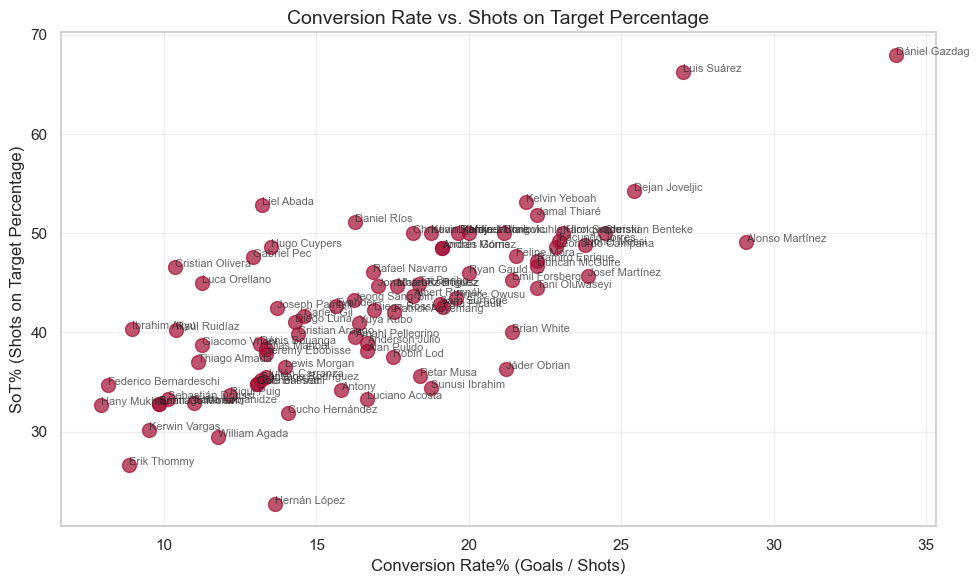

In [124]:
# Set a consistent style
sns.set(style="whitegrid")

# Scatter Plot: Conversion Rate vs. SoT%
plt.figure(figsize=(10, 6))
plt.scatter(
    result_efficiency['Conversion Rate (%)'],
    result_efficiency['SoT%'],
    color='#A30D33',
    alpha=0.7,
    s=100,
)
for i, player in enumerate(result_efficiency['Player']):
    plt.text(
        result_efficiency['Conversion Rate (%)'][i],
        result_efficiency['SoT%'][i],
        player,
        fontsize=8,
        alpha=0.7,
    )
plt.title("Conversion Rate vs. Shots on Target Percentage", fontsize=14)
plt.xlabel("Conversion Rate% (Goals / Shots)", fontsize=12)
plt.ylabel("SoT% (Shots on Target Percentage)", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


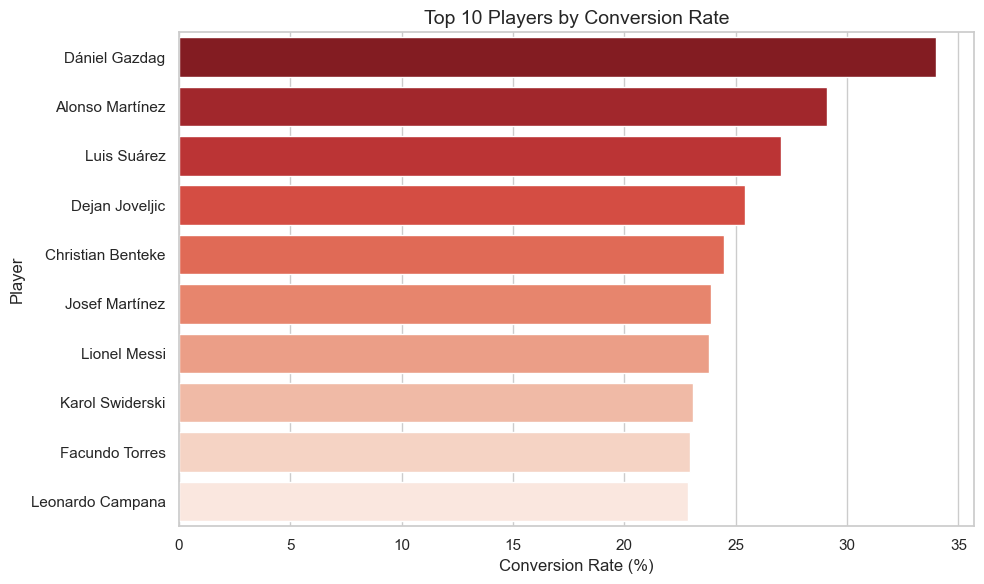

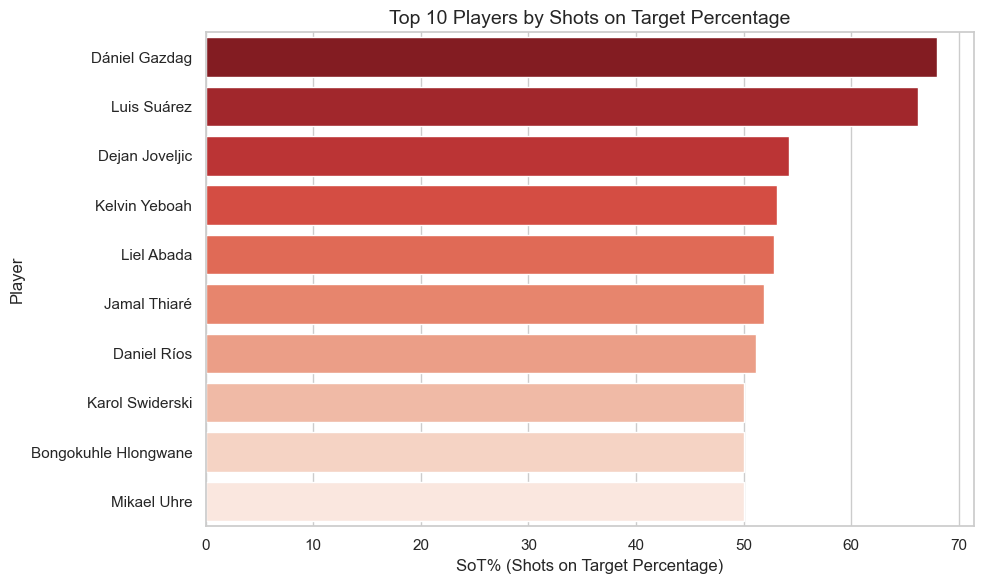

In [120]:
# Bar Chart: Top 10 Players by Conversion Rate
top_10_conversion = result_efficiency.nlargest(10, 'Conversion Rate (%)')
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Conversion Rate (%)',
    y='Player',
    data=top_10_conversion,
    palette="Reds_r",
)
plt.title("Top 10 Players by Conversion Rate", fontsize=14)
plt.xlabel("Conversion Rate (%)", fontsize=12)
plt.ylabel("Player", fontsize=12)
plt.tight_layout()
plt.show()

# Bar Chart: Top 10 Players by SoT%
top_10_sot = result_efficiency.nlargest(10, 'SoT%')
plt.figure(figsize=(10, 6))
sns.barplot(
    x='SoT%',
    y='Player',
    data=top_10_sot,
    palette="Reds_r",
)
plt.title("Top 10 Players by Shots on Target Percentage", fontsize=14)
plt.xlabel("SoT% (Shots on Target Percentage)", fontsize=12)
plt.ylabel("Player", fontsize=12)
plt.tight_layout()
plt.show()